# Assignment 1
Name: Jaimon Thypramabil Thomas
<br>StudentID : 29566428

## Section F. Logistic Regression vs. Bayesian Classifier
#### This task assesses your analytical skills. You need to study the performance of two well-known generative and discriminative models, i.e. Bayesian classifier and logistic regression, as the size of the training set increases. Then, you show your understanding of the behavior of learning curves of typical generative and discriminative models.
### Question 7 [Discriminative vs Generative Models, 25 Marks]
#### I. Load Task1E_train.csv and Task1E_test.csv as well as the Bayesian classifier (BC) and logistic regression (LR) codes from Activities 2 and 3 in Module 3.

#### Libraries Used

In [1]:
library(mvtnorm) # To calculate the densities
library(ggplot2) # used for generating plots

Warning message:
"package 'mvtnorm' was built under R version 3.6.2"Warning message:
"package 'ggplot2' was built under R version 3.6.3"

#### Loading data

In [2]:
#Reading data from csv
task1E_train <- read.csv("Task1E_train.csv")
task1E_test <- read.csv("Task1E_test.csv")
head(task1E_test)

x1,x2,y
3.4781571,-0.51546992,1
4.8959781,0.95320554,1
-0.5783557,5.44553527,-1
3.8417831,0.65759443,1
2.2649154,4.18082840,-1
3.8550566,-0.08328894,1


In [3]:
#Splitting train and test data into data and labels
train.data <- task1E_train[, -3]
train.label <- task1E_train[, 3]
test.data <- task1E_test[, -3]
test.label <- task1E_test[, 3]

In [4]:
#Function used to get total missclassification for train and test data after applying bayesian classification
bayesian.classifier <- function(train.data,train.label,test.data,test.label,class.labels){
    c0 <- class.labels[1]; c1 <- class.labels[2] # class labels
    # Class probabilities:
    # total number of samples in class 0 divided by the total nmber of training data
    p0.hat <- sum(train.label==c0)/nrow(train.data) 
    p1.hat <- sum(train.label==c1)/nrow(train.data) # or simply 1 - p1.hat  
    mu0.hat <- colMeans(train.data[train.label==c0,])
    mu1.hat <- colMeans(train.data[train.label==c1,])
    # class covariance matrices:
    sigma0.hat <- var(train.data[train.label==c0,])
    sigma1.hat <- var(train.data[train.label==c1,])

    # shared covariance matrix:
    sigma.hat <- p0.hat * sigma0.hat + p1.hat * sigma1.hat 
    # calculate posteriors:
    posterior0 <- p0.hat*dmvnorm(x=train.data, mean=mu0.hat, sigma=sigma.hat)
    posterior1 <- p1.hat*dmvnorm(x=train.data, mean=mu1.hat, sigma=sigma.hat)
    # calculate predictions:
    train.predict <- ifelse(posterior0 > posterior1, c0, c1)
    test.predict <- ifelse(p0.hat*dmvnorm(x=test.data, mean=mu0.hat, sigma=sigma.hat) > 
                           p1.hat*dmvnorm(x=test.data, mean=mu1.hat, sigma=sigma.hat), c0, c1)
    # calculate errors:
    train.error = sum(train.label!=train.predict)
    test.error = sum(test.label!=test.predict)
    return(c(train.error,test.error))
}

In [5]:
# auxiliary function that predicts class labels
predict <- function(w, X, c0, c1){
    sig <- sigmoid(w, X)
    return(ifelse(sig>0.5, c1,c0))
}
    
# auxiliary function that calculate a cost function
cost <- function (w, X, T, c0){
    sig <- sigmoid(w, X)
    return(sum(ifelse(T==c0, 1-sig, sig)))
}

# Sigmoid function (=p(C1|X))
sigmoid <- function(w, x){
    return(1.0/(1.0+exp(-w%*%t(cbind(1,x)))))    
}

#Function used to get total missclassification for train and test data after applying logistic regression
logistic.regression <-function(train.data,train.label,test.data,test.label,class.labels){
    c0 <- class.labels[1]; c1 <- class.labels[2] # class labels
    # Initializations
    #note that here for tau.max i have used dynamic value with respect to train.data instead of constant 1000 in 
    #activity 3 of module 3
    tau.max <- 5*nrow(train.data) # maximum number of iterations
    eta <- 0.01 # learning rate
    epsilon <- 0.01 # a threshold on the cost (to terminate the process)
    tau <- 1 # iteration counter
    terminate <- FALSE

    ## Just a few name/type conversion to make the rest of the code easy to follow
    X <- as.matrix(train.data) # rename just for conveniance
    T <- ifelse(train.label==c0,0,1) # rename just for conveniance

    W <- matrix(,nrow=tau.max, ncol=(ncol(X)+1)) # to be used to store the estimated coefficients
    W[1,] <- runif(ncol(W)) # initial weight (any better idea?)

    # project data using the sigmoid function (just for convenient)
    Y <- sigmoid(W[1,],X)

    costs <- data.frame('tau'=1:tau.max)  # to be used to trace the cost in each iteration
    costs[1, 'cost'] <- cost(W[1,],X,T, c0)
    train.len = nrow(train.data)
    while(!terminate){
        # check termination criteria:
        terminate <- tau >= tau.max | cost(W[tau,],X,T, c0)<=epsilon

        # shuffle data:
        train.index <- sample(1:train.len, train.len, replace = FALSE)
        X <- X[train.index,]
        T <- T[train.index]

        # for each datapoint:
        for (i in 1:train.len){
            # check termination criteria:
            if (tau >= tau.max | cost(W[tau,],X,T, c0) <=epsilon) {terminate<-TRUE;break}

            Y <- sigmoid(W[tau,],X)

            # Update the weights
            W[(tau+1),] <- W[tau,] - eta * (Y[i]-T[i]) * cbind(1, t(X[i,]))

            # record the cost:
            costs[(tau+1), 'cost'] <- cost(W[tau,],X,T, c0)

            # update the counter:
            tau <- tau + 1

            # decrease learning rate:
            eta = eta * 0.999
        }
    }
    # Done!
    costs <- costs[1:tau, ] # remove the NaN tail of the vector (in case of early stopping)

    # the  final result is:
    w <- W[tau,]
    # calculate predictions:
    train.predict <- predict(w,train.data,c0,c1)
    test.predict <- predict(w,test.data,c0,c1)
    # calculate errors:
    train.error = sum(train.label!=train.predict)
    test.error = sum(test.label!=test.predict)
    return(c(train.error,test.error))
    
}

note that in the logistic regression code, for the variable tau.max (i.e maximum no of iterations) I have used dynamic value with respect to train.data instead of constant 1000 as in activity 3 of module 3. So that we can see the difference in the plots more clearly with respect to train data size.

#### II. Using the first 5 data points from the training set, train a BC and a LR model, and compute their training and testing errors. In a “for loop”, increase the size of training set (5 data points at a time), retrain the models and calculate their training and testing errors until all training data points are used. In one figure, plot the training errors of the BC and LR models (with different colors) versus the size of the training set and in the other figure, plot the testing errors of the BC and LR models(with different colors) versus the size of the training set; include two plots in your Jupyter Notebook file for Question 7.

In [6]:
#function used to get errors for both bayesian classifier and logistic regression
get.error.for.bc.lr.byfactor <-function(train.data,train.label,test.data,test.label,factor=5){
    #data frame used to store errors
    error <- data.frame('data.size'=rep(0,nrow(train.data)/factor),'type'=rep(0,nrow(train.data)/factor)
                            ,'error'=rep(0,nrow(train.data)/factor)) 
    size = factor #used to denote the size of training data that is being used in each iteration
    i=1
    while(size<=nrow(train.data)){
        #extrating train data only for the particular size
        temp.train.data = train.data[1:size,]
        temp.train.label = train.label[1:size]
        class.labels = unique(train.label) #used to save unique classes in the label
        #storing the errors after applying bayesian classifier
        temp.error = bayesian.classifier(temp.train.data,temp.train.label,test.data,test.label,class.labels)
        error[i,'data.size'] = size
        error[i,'error'] = temp.error[2]
        error[i,'type'] = 'bayesian.classifier'
        i=i+1
        #storing the errors after applying logistic regression
        temp.error = logistic.regression(temp.train.data,temp.train.label,test.data,test.label,class.labels)
        error[i,'data.size'] = size
        error[i,'error'] = temp.error[2]
        error[i,'type'] = 'logistic.regression'
        i=i+1
        size = size + factor #incrementing size by factor
    }
    return(error)
}

In [7]:
#Extracting training and testing error for both bayesian classifier and logistic regression
errors.train = get.error.for.bc.lr.byfactor(train.data,train.label,train.data,train.label,factor=5)
errors.test = get.error.for.bc.lr.byfactor(train.data,train.label,test.data,test.label,factor=5)

#### For Training Data

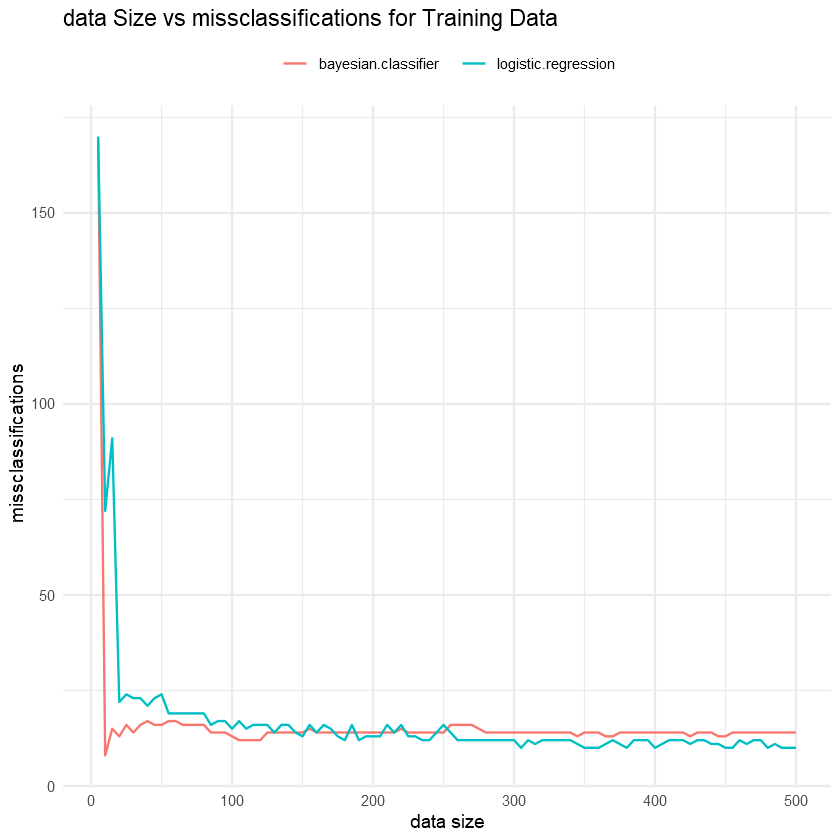

In [8]:
ggplot(data=errors.train, aes(x=data.size, y=error, color=type)) + geom_line() +
       scale_color_discrete(guide = guide_legend(title = NULL)) + theme_minimal()+ theme(legend.position="top") +
    labs( title= "data Size vs missclassifications for Training Data", y=" missclassifications",
               x = "data size")

#### For Testing Data

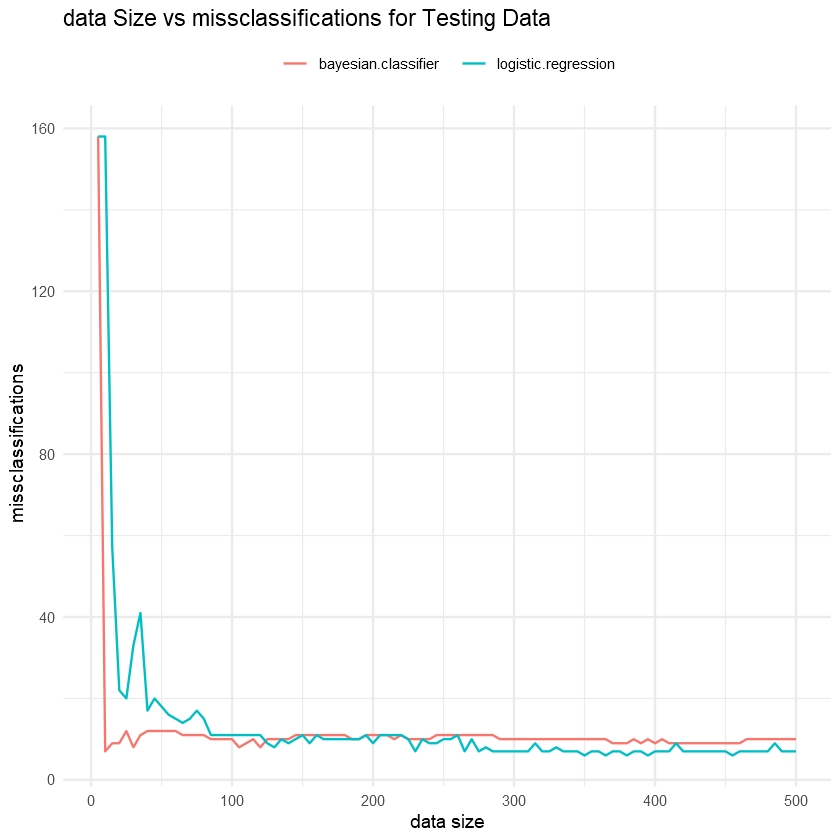

In [9]:
ggplot(data=errors.test, aes(x=data.size, y=error, color=type)) + geom_line() +
       scale_color_discrete(guide = guide_legend(title = NULL)) + theme_minimal() + theme(legend.position="top")+
    labs( title= "data Size vs missclassifications for Testing Data", y=" missclassifications",
                   x = "data size")

#### III. Explain your observations in your Jupyter Notebook file.:
#### a. What does happen for each classifier when the number of training data points is increased?

For the logistic regression we can see that as the no of data points increases the accuracy of the models is also increases. Whereas for the bayesian classifier we can see that after a particular point, we can see that the no of errors is almost constant irrespective of training data size.

#### b. Which classifier is best suited when the training set is small, and which is best suited when the training set is big?


Bayesian classifier is best suited for small training set and logistic regression is best suited for big training set.

#### c. Justify your observations in previous questions (III.a & III.b) by providing some speculations and possible reasons.
#### Hint: Think about model complexity and the fundamental concepts of machine learning covered in Module 1.

For logistic regression we can see that when the data is less training error is less but testing error is very high which implies that the model that we have generated might be overfitting that is it might be a complex model. That is also why as the amount of data increases the error is also decreasing as the complex models is able to explain the large amount of data well. Where as for bayesian model we can see that even for a small dataset both training and testing error is very low which implies it is more generalised or less complex model which is why even if data is increased there is no impact in the no of error.